### 1. 필요한 패키지 불러오기

In [327]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import re
from konlpy.tag import Mecab
from packages.utils import *

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [328]:
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

### 2. 다운로드 된 데이터 불러오기
데이터 출처
- https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [329]:
train_path = "./data/train" + "/*"
files_path = glob(train_path)

result = []
for path in files_path:
    with open(path, "r") as f:
        result += [f.readlines()]

english, korean = result

train = pd.DataFrame({"ko":korean, "en":english})

### 3. 전처리 전 데이터 살펴보기

In [330]:
i = 6
korean[i], english[i]

('국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.\n',
 'Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or who need help staying alert for longer periods of time, according to a new report by the National Academy of Sciences.\n')

In [331]:
train["ko_len"] = train["ko"].apply(lambda x: len(x))
train["en_len"] = train["en"].apply(lambda x: len(x))

train.head()

ko_mean_len, en_mean_len = train.describe().loc["mean", :]
ko_max_len, en_max_len = train.describe().loc["max", :]
ko_min_len, en_min_len = train.describe().loc["min", :]

print(f"훈련 데이터 개수 : {train.shape[0]}")
print("\n")
print(f"en 평균 길이 : {en_mean_len}")
print(f"en 최소 길이 : {en_min_len}")
print(f"en 최대 길이 : {en_max_len}")
print("\n")
print(f"ko 평균 길이 : {ko_mean_len}")
print(f"ko 최소 길이 : {ko_min_len}")
print(f"ko 최대 길이 : {ko_max_len}")

훈련 데이터 개수 : 94123


en 평균 길이 : 127.10869819279029
en 최소 길이 : 2.0
en 최대 길이 : 606.0


ko 평균 길이 : 61.78048935966767
ko 최소 길이 : 2.0
ko 최대 길이 : 378.0


### 4. 데이터 전처리

#### 4.1 공동 텍스트 전처리

In [332]:
train["ko"] = train["ko"].apply(lambda x : text_preprocessing(x))
train["en"] = train["en"].apply(lambda x : text_preprocessing(x))

#### 4.2 중복 데이터 제거

In [333]:
train = train.drop_duplicates("en", keep='first')
print(train.shape)
train = train.drop_duplicates("ko", keep='first')
print(train.shape)

(75442, 4)
(74581, 4)


#### 4.3 공백만 있는 데이터 제거

In [334]:
train = remove_nan(train)
print(train.shape)

(74579, 4)


#### 4.4 영어, 한국어 텍스트 전처리

In [335]:
mecab = Mecab()
def ko_pre(sentence):
    return mecab.morphs(sentence)


def en_pre(sentence):
    return ["<sos>"] + sentence.lower().split(" ") + ["<eos>"]

In [10]:
train["encoder_input"] = train["ko"].apply(lambda x : ko_pre(x))
train["pre_en"] = train["en"].apply(lambda x : en_pre(x))
train.head()

,ko,en,ko_len,en_len,encoder_input,pre_en
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐?,Much of personal computing is about can you to...,37,56,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<sos>, much, of, personal, computing, is, abo..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,53,122,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<sos>, so, a, mention, a, few, weeks, ago, ab..."
2,그러나 이것은 또한 책상도 필요로 하지 않는다,"Like all optical mice, But it also doesn t nee...",27,56,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다]","[<sos>, like, all, optical, mice,, but, it, al..."
3,"달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 ...",uses gyroscopic sensors to control the cursor ...,91,110,"[달러, 하, 는, 이, 최첨단, 무선, 광, 마우스, 는, 허공, 에서, 팔목, ...","[<sos>, uses, gyroscopic, sensors, to, control..."
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...,Intelligence officials have revealed a spate o...,120,225,"[정보, 관리, 들, 은, 동남, 아시아, 에서, 의, 선박, 들, 에, 대한, 많...","[<sos>, intelligence, officials, have, reveale..."


#### 4.5 토큰화 및 패딩을 포함한 벡터화

In [336]:
vocab_size = 5000

ko_bin_dict = bin_dict(train["encoder_input"])
ko_word_index, ko_index_word = word_index(ko_bin_dict, vocab_size)
encoder_input = tokenization(train["encoder_input"], ko_word_index)

en_bin_dict = bin_dict(train["pre_en"])
en_word_index, en_index_word = word_index(en_bin_dict, vocab_size)

train["decoder_input"] = train["pre_en"].apply(lambda x : x[:-1])
decoder_input = tokenization(train["decoder_input"], en_word_index, max_length = encoder_input.shape[1])

train["decoder_output"] = train["pre_en"].apply(lambda x : x[1:])
decoder_output = tokenization(train["decoder_output"], en_word_index, max_length = encoder_input.shape[1])

KeyError: 'encoder_input'

### 5. 전처리 후 데이터 살펴보기

In [278]:
train["pre_ko_len"] = train["encoder_input"].apply(lambda x: len(x))
train["pre_en_len"] = train["pre_en"].apply(lambda x: len(x))

train.head()

ko_mean_len, en_mean_len = train.describe().loc["mean", ["pre_ko_len", "pre_en_len"]]
ko_max_len, en_max_len = train.describe().loc["max", ["pre_ko_len", "pre_en_len"]]
ko_min_len, en_min_len = train.describe().loc["min", ["pre_ko_len", "pre_en_len"]]

print(f"훈련 데이터 개수 : {train.shape[0]}")
print("\n")
print(f"en 평균 단어 갯수 : {en_mean_len}")
print(f"en 최소 단어 갯수 : {en_min_len}")
print(f"en 최대 단어 갯수 : {en_max_len}")
print("\n")
print(f"ko 평균 단어 갯수 : {ko_mean_len}")
print(f"ko 최소 단어 갯수 : {ko_min_len}")
print(f"ko 최대 단어 갯수 : {ko_max_len}")

훈련 데이터 개수 : 74579


en 평균 단어 갯수 : 24.74652382037839
en 최소 단어 갯수 : 3.0
en 최대 단어 갯수 : 96.0


ko 평균 단어 갯수 : 28.41071883506081
ko 최소 단어 갯수 : 1.0
ko 최대 단어 갯수 : 125.0


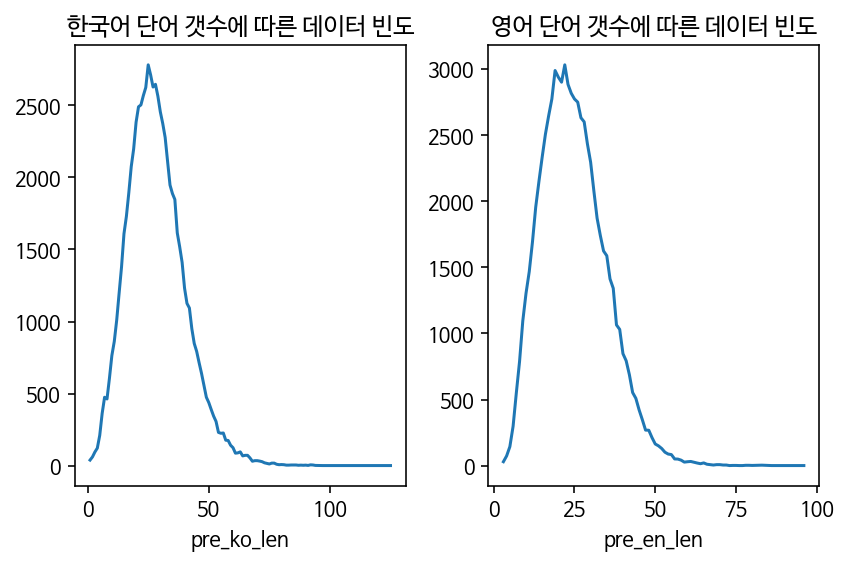

In [279]:
plt.subplot(1, 2, 1)
train.groupby("pre_ko_len").count().iloc[:,0].plot()
plt.title("한국어 단어 갯수에 따른 데이터 빈도")
plt.subplot(1, 2, 2)
train.groupby("pre_en_len").count().iloc[:,0].plot()
plt.title("영어 단어 갯수에 따른 데이터 빈도")

plt.tight_layout()
plt.show()

### 6. 텐서플로우 데이터셋 구축

In [191]:
reverse_encoder_input = np.array(list(map(lambda x : x[::-1], list(encoder_input))))
print(reverse_encoder_input.shape)
reverse_encoder_input

(74579, 125)


array([[ 591, 3369,   15, ...,    0,    0,    0],
       [ 412,   44,   29, ...,    0,    0,    0],
       [ 412,   44,   29, ...,    0,    0,    0],
       ...,
       [   4,   15,    5, ...,    0,    0,    0],
       [   4,   15,   14, ...,    0,    0,    0],
       [   4,    5, 2150, ...,    0,    0,    0]], dtype=int32)

In [20]:
buffer_size = len(train)
batch_size = 32
embedd_size = 100
hidden_size = 64
#tf_train = tensorflow_dataset((reverse_encoder_input, decoder_input), decoder_output, buffer_size, batch_size)
#tf_train

<tf.Tensor: shape=(2, 74579, 125), dtype=int32, numpy=
array([[[ 591, 3369,   15, ...,    0,    0,    0],
        [ 412,   44,   29, ...,    0,    0,    0],
        [ 412,   44,   29, ...,    0,    0,    0],
        ...,
        [   4,   15,    5, ...,    0,    0,    0],
        [   4,   15,   14, ...,    0,    0,    0],
        [   4,    5, 2150, ...,    0,    0,    0]],

       [[   0,    0,    0, ...,   85,  197,    1],
        [   0,    0,    0, ...,    1, 3707,    1],
        [   0,    0,    0, ...,  412,    9,    1],
        ...,
        [   0,    0,    0, ..., 1784,  895,    1],
        [   0,    0,    0, ..., 4227,    4, 1202],
        [   0,    0,    0, ..., 1140, 2054,  662]]], dtype=int32)>

### 7. 인코더-디코더 모델 구축

In [315]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [316]:
attn = BahdanauAttention(50)
decoder_hidden = tf.random.uniform((32, hidden_size))
encoder_output = tf.random.uniform((32, 125, hidden_size))
attn(encoder_output, decoder_hidden)

(<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
 array([[ 0.06147358, -0.19660173, -0.4667541 , ..., -0.65908015,
         -0.12946804,  0.67095023],
        [ 0.04353138, -0.20236662, -0.4246129 , ..., -0.6783301 ,
         -0.12544686,  0.6146525 ],
        [ 0.02815965, -0.19624159, -0.3945984 , ..., -0.60240144,
         -0.14034064,  0.59644604],
        ...,
        [ 0.04452415, -0.22647285, -0.44494236, ..., -0.6401871 ,
         -0.07186753,  0.63004917],
        [-0.0288532 , -0.17997596, -0.42690518, ..., -0.6152547 ,
         -0.09984954,  0.6389838 ],
        [ 0.05098133, -0.18438974, -0.4040901 , ..., -0.6226345 ,
         -0.11462824,  0.6393925 ]], dtype=float32)>,
 <tf.Tensor: shape=(32, 125, 1), dtype=float32, numpy=
 array([[[0.00412592],
         [0.01115234],
         [0.00569344],
         ...,
         [0.00968038],
         [0.00381556],
         [0.00978794]],
 
        [[0.00792814],
         [0.01223154],
         [0.01159938],
         ...,
         [0.0

LSTM args 의미 
- https://simpling.tistory.com/19
- return_sequence는 문장의 시점별 hidden state가 모두 나옵니다
- return_sequence는 보통 attention을 사용하기 위함입니다.
- return_state는 마지막 시점의 output, hidden_state, cell_state가 출력되며 output과 hidden_state는 동일합니다.

In [317]:
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedd_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedd = tf.keras.layers.Embedding(input_dim = vocab_size,
                                                output_dim = embedd_size)
        self.lstm1 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
        self.lstm2 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
        self.lstm3 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
        self.lstm4 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
    
    def call(self, encoder_input):
        # shape(1,125,100)
        encoder_input = self.embedd(encoder_input)
        # shape(1,125,64)
        encoder_input = self.lstm1(encoder_input)
        encoder_input = self.lstm2(encoder_input)
        encoder_input = self.lstm3(encoder_input)
        encoder_input = self.lstm4(encoder_input)
        return encoder_input

In [322]:
i = 10
ex = reverse_encoder_input[0:i]

ex_encoder = Encoder(vocab_size, embedd_size, hidden_size)
ex_encoder_output = encoder(ex)
ex_encoder_output

<tf.Tensor: shape=(10, 125, 64), dtype=float32, numpy=
array([[[ 4.53653556e-05,  1.60371219e-05,  3.68504552e-05, ...,
          4.01682009e-05, -3.74783049e-05, -1.71915362e-05],
        [ 1.29241758e-04,  3.78103905e-05,  7.72744970e-05, ...,
          1.19027580e-04, -6.51297960e-05, -3.26810659e-05],
        [ 2.69133277e-04,  5.37848900e-05,  1.16004703e-04, ...,
          2.53344129e-04, -1.20490622e-04, -3.51059462e-05],
        ...,
        [-2.38480791e-03, -2.92222667e-03,  5.05350064e-03, ...,
         -5.86639671e-03,  7.16284325e-04,  1.37792667e-02],
        [-2.38480885e-03, -2.92222830e-03,  5.05350018e-03, ...,
         -5.86639810e-03,  7.16283394e-04,  1.37792667e-02],
        [-2.38480978e-03, -2.92222947e-03,  5.05350018e-03, ...,
         -5.86639950e-03,  7.16282404e-04,  1.37792658e-02]],

       [[ 1.47914279e-05,  2.02844512e-05,  5.60552508e-07, ...,
         -1.56568785e-05,  1.74504021e-05,  7.08690959e-06],
        [-1.93645174e-05,  4.07825719e-05,  1.36

In [325]:
class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedd_size, hidden_size):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedd = tf.keras.layers.Embedding(input_dim = vocab_size,
                                                output_dim = embedd_size)
        self.lstm1 = tf.keras.layers.LSTM(hidden_size, 
                                          return_sequences = True,
                                          return_state = True)
        
        self.attention = BahdanauAttention(self.hidden_size)
        
        self.outputs = tf.keras.layers.Dense(vocab_size, activation = "softmax")
        
    def call(self, decoder_input, decoder_hidden, encoder_output):
        
        context_vec, attn = self.attention(encoder_output, decoder_hidden)
        
        
        decoder_input = self.embedd(decoder_input)
        decoder_input = tf.concat([context_vec, decoder_input], axis=-1)
        
#        decoder_input, decoder_hidden, _ = self.lstm1(decoder_input)
#        decoder_input = tf.reshape(decoder_input, (-1, decoder_input.shape[2]))
#        decoder_input = self.outputs(decoder_input)
        return decoder_input

In [326]:
ex_decoder_output = decoder_input[0:i]

ex_decoder_hidden = tf.random.uniform((i, hidden_size))

ex_decoder = Decoder(vocab_size, embedd_size, hidden_size)
ex_pred = ex_decoder(ex_decoder_output, 
                                         ex_decoder_hidden, 
                                         ex_encoder_output)
# result, hidden, attn = outputs
# print(result.shape)
# print(attn.shape)
ex_pred

InvalidArgumentError: ConcatOp : Ranks of all input tensors should match: shape[0] = [10,64] vs. shape[1] = [10,125,100] [Op:ConcatV2] name: concat

In [237]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [299]:
print(reverse_encoder_input.shape)
print(decoder_input.shape)
print(decoder_output.shape)

batch_encoder_input = reverse_encoder_input[:32,:]
batch_decoder_input = decoder_input[:32,:]
batch_decoder_output = decoder_output[:32,:]

(74579, 125)
(74579, 125)
(74579, 125)


In [305]:
vocab_size = 5000
batch_size = 32
embedd_size = 100
hidden_size = 64

encoder = Encoder(vocab_size, embedd_size, hidden_size)
decoder = Decoder(vocab_size, embedd_size, hidden_size)

encoder_output = encoder(batch_encoder_input)
batch_decoder_hidden = encoder_output[:, -1]
loss = 0
t = 1
pred, batch_decoder_hidden, _ = decoder(batch_decoder_input, 
                                        batch_decoder_hidden, 
                                        encoder_output)
#loss += loss_function(batch_decoder_output[:,t], pred)
pred

<tf.Tensor: shape=(32, 125, 5000), dtype=float32, numpy=
array([[[0.00020024, 0.0001999 , 0.00020036, ..., 0.00019997,
         0.00020016, 0.00020016],
        [0.00020039, 0.00019983, 0.00020057, ..., 0.00019995,
         0.0002003 , 0.00020028],
        [0.00020047, 0.00019978, 0.0002007 , ..., 0.00019994,
         0.00020041, 0.00020037],
        ...,
        [0.00019983, 0.00020009, 0.00019978, ..., 0.00020015,
         0.00020011, 0.00020034],
        [0.00019993, 0.00020014, 0.00019982, ..., 0.00020031,
         0.00020018, 0.00020019],
        [0.00020019, 0.00020004, 0.00019973, ..., 0.00020029,
         0.00020028, 0.00020014]],

       [[0.00020024, 0.0001999 , 0.00020036, ..., 0.00019997,
         0.00020016, 0.00020016],
        [0.00020039, 0.00019983, 0.00020057, ..., 0.00019995,
         0.0002003 , 0.00020028],
        [0.00020047, 0.00019978, 0.0002007 , ..., 0.00019994,
         0.00020041, 0.00020037],
        ...,
        [0.00020035, 0.00019959, 0.00019983, ..., 0

In [302]:
batch_decoder_output[:,t].shape

(32,)

In [226]:
encoder_output[:,-1]

<tf.Tensor: shape=(32, 64), dtype=float32, numpy=
array([[-0.00167533,  0.00269996,  0.00798906, ...,  0.01256416,
        -0.01775637,  0.00054503],
       [-0.00167531,  0.00269998,  0.00798908, ...,  0.01256413,
        -0.01775636,  0.00054507],
       [-0.00167534,  0.00269995,  0.00798906, ...,  0.01256418,
        -0.01775637,  0.00054503],
       ...,
       [-0.00167531,  0.00270007,  0.00798909, ...,  0.012564  ,
        -0.01775629,  0.00054512],
       [-0.00167532,  0.00269996,  0.00798907, ...,  0.01256415,
        -0.01775637,  0.00054504],
       [-0.00167531,  0.00269998,  0.00798907, ...,  0.01256415,
        -0.01775637,  0.00054505]], dtype=float32)>

In [175]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [176]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

NameError: name 'enc_train' is not defined